# Nucleus Dataset

- This image data set was created for the Kaggle 2018 Data Science Bowl sponsored by Booz Allen Hamilton with cash prizes.

- It's the image set [BBBC038](https://data.broadinstitute.org/bbbc/BBBC038/) available from the [Broad Bioimage Benchmark Collection](https://data.broadinstitute.org/bbbc/index.html) ([Ljosa et al., Nature Methods, 2012](http://dx.doi.org/10.1038/nmeth.2083)).

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
import tqdm
from PIL import Image

import sys; sys.path.append("../../../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Nucleus")

data_dir = root_dir / "Data"
data_dir.mkdir(parents=True, exist_ok=True)

raw_data_dir = root_dir / "Raw Data"
raw_data_dir.mkdir(parents=True, exist_ok=True)

config = maskflow.config.load_config("config.yaml")

# Copy config next to data folder
maskflow.config.save_config(config, root_dir / "config.yaml")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Build the dataset

In [2]:
# Download the raw data if needed
if len(list(raw_data_dir.glob("*"))) == 0:
    dataset_url = "https://data.broadinstitute.org/bbbc/BBBC038/stage1_train.zip"
    maskflow.utils.download_zip(dataset_url, raw_data_dir)
    
training_size = 0.8  # From 0 to 1
png_compression_level = 0  # From 0 to 9

dirnames = list(raw_data_dir.iterdir())[:]
len_dataset = len(dirnames)

train_ids, _ = train_test_split(np.arange(0, len_dataset), train_size=training_size)

train_dir = data_dir / "train_dataset"
train_dir.mkdir(parents=True, exist_ok=True)

test_dir = data_dir / "test_dataset"
test_dir.mkdir(parents=True, exist_ok=True)

train_annotations_path = data_dir / "train_annotations.json"
test_annotations_path = data_dir / "test_annotations.json"

train_annotations = maskflow.dataset.get_base_annotations(['nucleus'], supercategory="nucleus")
test_annotations = maskflow.dataset.get_base_annotations(['nucleus'], supercategory="nucleus")

for image_id, dirpath in enumerate(tqdm.tqdm(dirnames, total=len(dirnames))):
    # Open the image and remove the alpha channel
    im_path = dirpath / "images" / (dirpath.stem + ".png")
    image = np.array(Image.open(im_path))[:, :, :3]
    
    masks = []
    for mask_path in (dirpath / "masks").glob("*.png"):
        mask = np.array(Image.open(mask_path))
        masks.append(mask)
    masks = np.array(masks)
    
    # Crop the image and mask to MAX_SIZE_TRAIN
    # TODO: this is not ideal to do it here and should be done
    # in the model directly. But the current one resizes the input
    # instead of cropping it which modify the scale.

    max_size = config['INPUT']['MAX_SIZE_TRAIN']
    w, h = image.shape[:2]
    
    # We simply exclude image bigger than MAX_SIZE
    if w > max_size or h > max_size:
        # print(f'Exclude {dirpath.stem}')
        continue

    crop_w = 0
    crop_h = 0
    if w < max_size or h < max_size:
        if w < max_size:
            crop_w = max_size - w
        if h < max_size:
            crop_h = max_size - h

        new_image = np.zeros((w + crop_w, h + crop_h, image.shape[-1]))
        new_image[:w, :h] = image
        image = new_image.astype('uint8')

        new_masks = np.zeros((masks.shape[0], w + crop_w, h + crop_h))
        new_masks[:, :w, :h] = masks
        masks = new_masks
    
    class_ids = np.ones([masks.shape[0]], dtype=np.int32)
    
    basename = f"nucleus_{image_id:04d}.png"
    
    # Get the annotation in the COCO format.
    image_info, image_annotations = maskflow.dataset.get_annotations(image_id, basename, image, masks, class_ids)
    
    if image_id in train_ids:
        image_path = train_dir / basename
        train_annotations["images"].append(image_info)
        train_annotations["annotations"].extend(image_annotations)
    else:
        image_path = test_dir / basename
        test_annotations["images"].append(image_info)
        test_annotations["annotations"].extend(image_annotations)
    
    Image.fromarray(image).save(str(image_path), compress_level=png_compression_level)
    
maskflow.dataset.save_annotations(train_annotations, train_annotations_path)
maskflow.dataset.save_annotations(test_annotations, test_annotations_path)

/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
100%|██████████| 670/670 [01:55<00:00,  5.79it/s]


## Check the dataset

2018-11-04 17:29:58,993:WARNING:maskrcnn_benchmark.data.build: When using more than one image per GPU you may encounter an out-of-memory (OOM) error if your GPU does not have sufficient memory. If this happens, you can reduce SOLVER.IMS_PER_BATCH (for training) or TEST.IMS_PER_BATCH (for inference). For training, you must also adjust the learning rate and schedule length according to the linear scaling rule. See for example: https://github.com/facebookresearch/Detectron/blob/master/configs/getting_started/tutorial_1gpu_e2e_faster_rcnn_R-50-FPN.yaml#L14


loading annotations into memory...
Done (t=0.44s)
creating index...
index created!


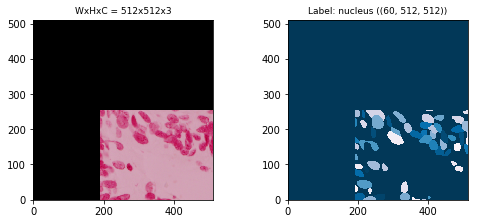

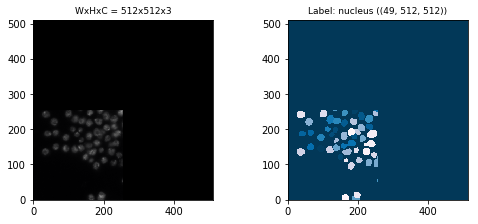

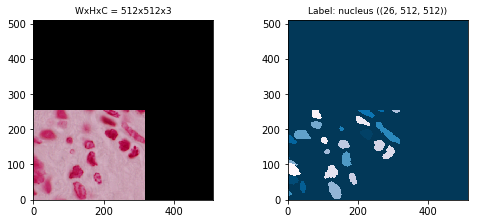

In [4]:
config['SOLVER']['IMS_PER_BATCH'] = 3
config['TEST']['IMS_PER_BATCH'] = 3

# Number of batch to load
n = 1

# Load some data
data_loader = maskflow.dataset.get_data_loader(config, data_dir, is_train=True)
some_data = [iter(data_loader).next() for _ in range(n)]

# Retrieve category's names
categories = data_loader.dataset.coco.cats

for batch_image, batch_target, batch_idx in some_data:
    maskflow.viz.batch_display_top_masks(batch_image, batch_target, batch_idx, categories,
                                         basesize=7, limit=1, cmap="PuBu_r",
                                         pixel_mean=config['INPUT']['PIXEL_MEAN'],
                                         pixel_std=config['INPUT']['PIXEL_STD'])